In [ ]:
import cv2 as cv
import albumentations as A
import os
import sys
import datetime
import io

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import (
    Conv2D,
    MaxPool2D,
    Dense,
    Flatten,
    Input,
    BatchNormalization,
    Layer,
    InputLayer,
    Dropout,
    Resizing,
    Rescaling,
    RandomFlip,
    RandomRotation,
    GlobalAveragePooling2D,
    Add,
    MultiHeadAttention,
    Embedding,
    LayerNormalization,
    Permute,
)
from tensorflow.keras.losses import (
    BinaryCrossentropy,
    CategoricalCrossentropy,
    SparseCategoricalCrossentropy,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import (
    CategoricalAccuracy,
    TopKCategoricalAccuracy,
)
from tensorflow.keras.callbacks import (
    Callback,
    CSVLogger,
    EarlyStopping,
    LearningRateScheduler,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
from tensorflow.keras.regularizers import L2, L1
import tensorflow_probability as tfp
from tensorboard.plugins.hparams import api as hp

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve

CLASS_NAMES = ["angry", "happy", "sad"]  # This needs to be in accord with dir names.

CONFIG = {
    "batch_size": 32,
    "im_shape": (256, 256),
    "im_size": 256,
    "input_shape": (None, None, 3),
    "filters_1": 6,
    "filters_2": 16,
    "kernel_size": 3,
    "activation_1": "relu",
    "activation_2": "softmax",
    "dropout": 0.01,
    # "dropout": 0.00,
    "regularization_l2": 0.1,
    # "regularization_l2": 0.0,
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "pool_size": 2,
    "strides_1": 1,
    "strides_2": 2,
    "dense_1": 32,
    "dense_2": 32,
    "dense_3": 32,
    "dense_out": 3,
    "learning_rate": 0.001,
    "batch_size": 32,
    "epochs": 25,
    "patch_size":16,
    "class_names":CLASS_NAMES,
    "class_size":len(CLASS_NAMES),
}

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
TRAIN_DIR = "/content/drive/MyDrive/tfds_data/datasets/Emotions Dataset/Emotions Dataset/train"
TEST_DIR = "/content/drive/MyDrive/tfds_data/datasets/Emotions Dataset/Emotions Dataset/test"

# TRAIN_DIR = "./datasets/Emotions Dataset/Emotions Dataset/train"
# TEST_DIR = "./datasets/Emotions Dataset/Emotions Dataset/test"

train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    # NOTE: int -> [0,1,2]; categorical -> (1,0,0) | (0,1,0) | (0,0,1)
    label_mode="categorical",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=CONFIG["batch_size"],
    # batch_size=None,
    image_size=CONFIG["im_shape"],
    shuffle=True,
    seed=10,
).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    # NOTE: int -> 0 | 1 | 2; categorical -> (1,0,0) | (0,1,0) | (0,0,1)
    label_mode="categorical",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=CONFIG["batch_size"],
    # batch_size=None,
    image_size=CONFIG["im_shape"],
    shuffle=True,
    seed=10,
)

Mounted at /content/drive
Found 4680 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


In [ ]:
# !pip install transformers

## Integrating TFViTModel V1 (Deprecated)

In [ ]:
# Original Way (not working)
from transformers import TFViTModel, ViTConfig

base_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

resize_rescale_permute = tf.keras.Sequential([
    Resizing(224, 224),
    Rescaling(1/255.),
    # from (None, 224, 224, 3) to (None, 3, 224, 224)
    Permute((3, 1, 2)),
])

inputs = tf.keras.Input(shape=(256, 256, 3))
x = resize_rescale_permute(inputs)
"""
Data of type <class 'keras.src.backend.common.keras_tensor.KerasTensor'> is not
allowed only (<class 'tensorflow.python.framework.tensor.Tensor'>, <class 'bool'>,
<class 'int'>, <class 'transformers.utils.generic.ModelOutput'>, <class 'tuple'>,
<class 'list'>, <class 'dict'>, <class 'numpy.ndarray'>) is accepted for pixel_values.
"""
# x = base_model(x)
x = base_model.vit()(x)

x = Dense(len(CLASS_NAMES), activation="softmax")(x)

# Hugging Face
hf_model = Model(inputs=inputs, outputs=x)

hf_model.summary()

## Integrating TFViTModel V2 (layers.Lambda)

In [ ]:
# Also Works
from transformers import TFViTModel

base_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

resize_rescale_permute = tf.keras.Sequential([
    Resizing(224, 224),
    Rescaling(1/255.),
    # from (None, 224, 224, 3) to (None, 3, 224, 224)
    Permute((3, 1, 2)),
])

inputs = tf.keras.Input(shape=(256, 256, 3))

# Hugging Face
hf_model = tf.keras.Sequential([
    inputs,
    resize_rescale_permute,
    # [0][:,0,:]
    # -> [0] >> Takes the last_hidden_states tensor of shape (1, 197, 768)
    # -> [:,0,:] >> Takes only the class embedding/final class token
    #    (the summary of all embeddings in the transformer archtecture).
    tf.keras.layers.Lambda(lambda x: base_model(x)[0][:,0,:]),
    Dense(len(CLASS_NAMES), activation="softmax"),
])

hf_model.summary()

## Integrating TFViTModel V3 (Wrapper)

In [ ]:
from transformers import TFViTModel, ViTConfig

base_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

resize_rescale_permute = tf.keras.Sequential([
    Resizing(224, 224),
    Rescaling(1/255.),
    # from (None, 224, 224, 3) to (None, 3, 224, 224)
    Permute((3, 1, 2)),
])

inputs = tf.keras.Input(shape=(256, 256, 3))
x = resize_rescale_permute(inputs)
# x = tf.convert_to_tensor(x) # Not allowed.
# x = base_model.vit(x)
# NOTE: This below Works, but it's more limited than the Wrapper approach.
# x = tf.keras.layers.Lambda(lambda param: base_model(param)[0][:,0,:])(x)

"""
This wrapper is necessary because
<class 'keras.src.backend.common.keras_tensor.KerasTensor'> is not allowed
inside base_model of type <class 'transformers.modeling_tf_vit.TFViTModel'>.
"""
class Wrapper(Layer):
  def __init__(self, base_model):
    super().__init__(name="wrapper")
    self.base_model = base_model

  def call(self, x):
    # [0][:,0,:]
    # -> [0] >> Takes the last_hidden_states tensor of shape (1, 197, 768)
    # -> [:,0,:] >> Takes only the class embedding/final class token
    #    (the summary of all embeddings in the transformer archtecture).
    return self.base_model(x)[0][:,0,:]

  def build(self, input_shape):
    pass
    # self.trainable = True
    # For finetuning (Remember to verify if this is enough to integrate
    # base_model with the training of keras).
    # for layer in self.base_model.layers:
    #     layer.trainable = True

  # This method is used for saving the model with model.save()
  def get_config(self):
    # Return a dictionary containing the configuration of this layer
    config = super().get_config()
    config.update({
        "base_model": self.base_model.config.to_dict()  # Serialize the config of the base model
    })
    return config

x = Wrapper(base_model)(x)
x = Dense(len(CLASS_NAMES), activation="softmax")(x)

# Hugging Face
hf_model = Model(inputs=inputs, outputs=x)

hf_model.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy(), TopKCategoricalAccuracy(k=2)],
)

hf_model.summary()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ wrapper (Wrapper)                    │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           2,307 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,307 (9.01 KB)

 Trainable params: 2,307 (9.01 KB)

 Non-trainable params: 0 (0.00 B)

## Running

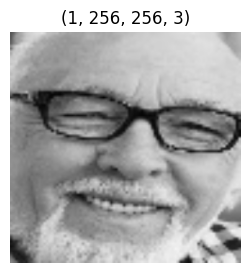

In [ ]:
# img = cv.imread("./datasets/Emotions Dataset/Emotions Dataset/test/happy/43189.jpg")[:,:,::-1]
img = cv.imread("/content/drive/MyDrive/tfds_data/datasets/Emotions Dataset/Emotions Dataset/test/happy/43189.jpg")[:,:,::-1]
img = cv.resize(img, (256, 256))
img = tf.constant(img, dtype=tf.float32)
img = tf.expand_dims(img, axis=0)

plt.figure(figsize=[3,3])
plt.imshow(img[0]/255.0)
plt.title(img.shape)
plt.axis("off")
plt.show()

In [ ]:
"""
>> Hidden states are the representations of the tokens after the model has processed
the input through its layers. They are the result of applying the transformer’s
self-attention and feed-forward layers to the input embeddings.
>> In the context of transformer-based models like BERT, GPT, or similar, the
"last hidden state" refers to the output of the final layer of the transformer.
>> The pooler_output is used as a representation of the entire sequence. This is
typically fed into a classifier (e.g., a softmax layer or a linear layer) to
predict the label or class for the input sequence.
"""
"""
[0][:,0,:]
-> [0] >> Takes the last_hidden_states tensor of shape (1, 197, 768)
-> [:,0,:] >> Takes only the class embedding /final class token (the summary
   of all embeddings in the transformer archtecture).
"""
hf_model(img).shape

TensorShape([1, 3])

In [ ]:
# I think it's not shuffling.
hf_model.fit(train_dataset.shuffle(buffer_size=20).take(20), validation_data=test_dataset.take(20), epochs=20, verbose=1)
# hf_model.fit(train_dataset, validation_data=test_dataset, epochs=20, verbose=1)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - categorical_accuracy: 0.4524 - loss: 1.0409 - top_k_categorical_accuracy: 0.8308 - val_categorical_accuracy: 0.3609 - val_loss: 1.1109 - val_top_k_categorical_accuracy: 0.6828
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 756ms/step - categorical_accuracy: 0.4353 - loss: 1.0407 - top_k_categorical_accuracy: 0.8425 - val_categorical_accuracy: 0.3750 - val_loss: 1.1082 - val_top_k_categorical_accuracy: 0.7031
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 773ms/step - categorical_accuracy: 0.4926 - loss: 0.9837 - top_k_categorical_accuracy: 0.8884 - val_categorical_accuracy: 0.3891 - val_loss: 1.1009 - val_top_k_categorical_accuracy: 0.7000
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 791ms/step - categorical_accuracy: 0.5385 - loss: 0.9497 - top_k_categorical_accuracy: 0.9204 - val_categorical_accuracy: 0.3812 - val_loss: 1.1096 - val_top_k_categorical_accuracy: 0.6938
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 800ms/step - categorical_accuracy: 0.

# Wandb Setup

In [ ]:
# !pip install wandb
!wandb login

import wandb
from wandb.integration.keras import WandbMetricsLogger

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
hf_model.predict(test_dataset.take(2), verbose=1).shape

2/2 ━━━━━━━━━━━━━━━━━━━━ 77s 33s/step


(64, 3)

In [ ]:
for im, label in test_dataset.unbatch().take(25):
        im = tf.expand_dims(im, axis=0)
        print(tf.argmax(hf_model.predict(im), axis=-1).numpy())
        y_true = CLASS_NAMES[tf.argmax(label, axis=-1).numpy()]
        y_pred = CLASS_NAMES[tf.argmax(hf_model.predict(im), axis=-1).numpy()[0]]
        row = [im, y_pred, y_true]
        print(row[0].shape, row[1], row[2])
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [ ]:
class ConfusionMatrixWandbLogger(Callback):
    def __init__(self):
        super().__init__()

    def on_train_end(self, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []

        # (x, 3)
        dataset = test_dataset.take(10)

        for image_b, label_b in dataset:
          # NOTE: Doing the np.argmax here to avoid putting all vectors of size
          # 3 inside the lists.
          y_true.append(np.argmax(label_b, axis=-1))
          y_pred.append(np.argmax(hf_model.predict(image_b, verbose=0), axis=-1))

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        # This concatenate handles the fact that the size of the dataset not necessarely
        # is divisible by the size of the batch.
        y_true = np.concatenate([y_true[:-1].flatten(), y_true[-1].flatten()])
        y_pred = np.concatenate([y_pred[:-1].flatten(), y_pred[-1].flatten()])

        cm = wandb.plot.confusion_matrix(
            y_true=y_true, preds=y_pred, class_names=CONFIG["class_names"]
        )
        wandb.log({"conf_matrix":cm})

class TableWandbLogger(Callback):
    def __init__(self):
      super().__init__()

    def on_epoch_end(self, epoch, logs=None):
      table = wandb.Table(columns=["image", "predicted", "label"])

      for im, label in test_dataset.unbatch().take(25):
        im = tf.expand_dims(im, axis=0)
        # print(tf.argmax(hf_model.predict(im), axis=-1).numpy())
        y_true = CLASS_NAMES[tf.argmax(label, axis=-1).numpy()]
        y_pred = CLASS_NAMES[tf.argmax(hf_model.predict(im, verbose=0), axis=-1).numpy()[0]]
        row = [wandb.Image(im), y_pred, y_true]
        table.add_data(*row)

      wandb.log({"Model Results":table})

In [ ]:
with wandb.init(project="Emotion-Detection", entity="albertalvin8080-academic", config=CONFIG) as run:
    hf_model.fit(
        train_dataset.take(20),
        validation_data=test_dataset,
        epochs=1,
        verbose=1,
        callbacks=[WandbMetricsLogger(), ConfusionMatrixWandbLogger(), TableWandbLogger()],
    )

# ONNX (Open Neural Network Exchange)

In [ ]:
!pip install tf2onnx
!pip install onnxruntime
# !pip install onnxruntime-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 77.5 MB/s eta 0:00:00


In [ ]:
# hf_model.save("vit_finetuned")
# SavedModel format (which is used by TensorFlow for deployment with TensorFlow Lite or TensorFlow Serving)
hf_model.export("vit_finetuned")
!python -m tf2onnx.convert --saved-model vit_finetuned/ --output vit_onnx.onnx

Saved artifact at 'vit_finetuned'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  133104705199744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133104703181168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133104705198688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133104703048336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133104703184336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133104705200448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133109170104880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133104707716368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133104704243664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133104704245600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133104705149008: 

In [ ]:
# Converting vit_finetuned.h5 to *.onnx
hf_model.save("vit_finetuned.h5")

import tf2onnx
import onnxruntime as rt

# CONFIG["im_size"] = 256
spec = [tf.TensorSpec((None, CONFIG["im_size"], CONFIG["im_size"], 3), tf.float32, name="input")]

"""
>> The opset (operation set) defines the version of the ONNX operators that are
used in the conversion. Each ONNX release comes with an updated set of operators,
each with its own version. These operators define the available computational
operations (such as matrix multiplication, activation functions, etc.) in the ONNX format.
>> In ONNX, the output names are the names of the output tensors that the model
produces during inference. These are used to identify the output tensors when
running inference with the ONNX model.
>> The model_proto is the ONNX model represented as a Protocol Buffers (protobuf)
object. When you convert your TensorFlow model to ONNX using tf2onnx.convert.from_keras(),
it produces a model_proto object. This object contains the full representation
of the ONNX model, including its layers, operations, and tensors, as well as
metadata such as input and output shapes and names.
>> A Protocol Buffer (often abbreviated as protobuf) is a language-neutral,
platform-neutral, extensible mechanism for serializing structured data.
"""
output_path = "vit_h5.onnx"
model_proto, _ = tf2onnx.convert.from_keras(
    hf_model,
    input_signature=spec,
    opset=13,
    output_path=output_path,
)

output_names=[n.name for n in model_proto.graph.output]

In [ ]:
# img = cv.imread("./datasets/Emotions Dataset/Emotions Dataset/test/happy/43189.jpg")[:,:,::-1]
im = cv.imread("/content/drive/MyDrive/tfds_data/datasets/Emotions Dataset/Emotions Dataset/test/happy/43189.jpg")[:,:,::-1]
im = cv.resize(im, (256, 256))
im = tf.constant(im, dtype=tf.float32)
im = tf.expand_dims(im, axis=0)

In [ ]:
providers = ["CUDAExecutionProvider", "CPUExecutionProvider"] # If the first isnt available, uses the latter.
model = rt.InferenceSession(output_path, providers=providers)
onnx_pred = model.run(output_names, {"input":im.numpy()})
print(onnx_pred)
print(rt.get_device())

CPU


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


[array([[0.22118872, 0.5982765 , 0.18053485]], dtype=float32)]


# ONNX PTQ (Post Training Quantization)

In [ ]:
# https://netron.app/ -> Vizualize ONNX models internally (very cool stuff).
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

In [ ]:
model_fp32 = "/content/vit_h5.onnx"
model_quant = "/content/vit_quantized.onnx"

quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type=QuantType.QUInt8)

In [ ]:
providers = ["CPUExecutionProvider"]
m = rt.InferenceSession("/content/vit_quantized.onnx", providers=providers)

m.run(output_names, {"input": im.numpy()})

[array([[0.24106753, 0.38140106, 0.37753135]], dtype=float32)]

In [ ]:
dir(base_model)
# print(base_model.output)

# Quantization Aware Training (QAT)

In [ ]:
!pip install tensorflow_model_optimization

In [ ]:
import tensorflow_model_optimization as tfmot

In [ ]:
backbone = tf.keras.applications.EfficientNetB4(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3),
)
backbone.trainable = False # Transfer Learning

x = GlobalAveragePooling2D()(backbone.output)
x = Dense(32, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(32, activation="relu")(x)
x = Dense(CONFIG["class_size"], activation="softmax")(x)

effnet = Model(inputs=backbone.input, outputs=x)
# effnet.summary()

In [ ]:
# NOTE: There's some error that tfmot.quantization.keras.quantize_annotate_layer
# is not recognizing the layers.
def annotate_for_quantization(layer):
  # print(layer.name)
  # print(f"Layer type: {type(layer)}, {isinstance(layer, (tf.keras.layers.Layer))}")
  # if "conv" in layer.name:
  if isinstance(layer, (tf.keras.layers.Dense)):
    return tfmot.quantization.keras.quantize_annotate_layer(layer)
  return layer

effnet_quant_annotated = tf.keras.models.clone_model(
    effnet, clone_function=annotate_for_quantization
)
effnet_quant_annotated.summary()

In [ ]:
# From now you just need to train using fit with this quantized model.
effnet_quant = tfmot.quantization.keras.quantize_apply(effnet_quant_annotated)

# TFLite for mobile and edge devices

In [ ]:
!pip list | grep tensorflow
!pip install tflite
!pip3 install tflite-runtime

In [ ]:
backbone = tf.keras.applications.EfficientNetB4(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3),
)
backbone.trainable = False # Transfer Learning

x = GlobalAveragePooling2D()(backbone.output)
x = Dense(32, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(32, activation="relu")(x)
x = Dense(CONFIG["class_size"], activation="softmax")(x)

effnet = Model(inputs=backbone.input, outputs=x)
# effnet.summary()
effnet.save("effnet.h5")

In [ ]:
def callibration_data_generator():
  for image, label in train_dataset.take(20):
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(effnet)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
# NOTE: Remove this below if you want Dynamic Quantization instead of Static Quantization.
converter.representative_dataset = callibration_data_generator

converted_model = converter.convert()

import pathlib

tflite_dir = pathlib.Path("/content/effnet.tflite")
tflite_dir.write_bytes(converted_model)

In [ ]:
import tflite_runtime.interpreter as tflite

# img = cv.imread("./datasets/Emotions Dataset/Emotions Dataset/test/happy/43189.jpg")[:,:,::-1]
img = cv.imread("/content/drive/MyDrive/tfds_data/datasets/Emotions Dataset/Emotions Dataset/test/happy/43189.jpg")[:,:,::-1]
img = cv.resize(img, (256, 256))
img = np.expand_dims(img, axis=0)

interpreter = tflite.Interpreter(model_path="/content/effnet.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

print(f"dtype :: {input_details['dtype']}\nindex :: {input_details['index']}")

img = img.astype(dtype=input_details["dtype"])
interpreter.set_tensor(input_details["index"], img)

interpreter.invoke()

output = interpreter.get_tensor(output_details["index"])[0]
# NOTE: If the output is something like [94 70 92] it's because you didn't train the model.
print(output)

dtype :: <class 'numpy.uint8'>
index :: 0
[93 70 93]
